In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [73]:
# I use Google Colab as my IDE so it's more convienient
# for me to use my google drive
dataset = pd.read_csv("drive/MyDrive/neuron_workplace/autentykacja_eeg.csv", delimiter=";")

In [74]:
dataset.head()

,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength,Flag
0,785389,114375,57106,37625,24464,17104,15846,8024,45,91,15,1
1,386949,80792,23506,22118,9566,7147,5392,1697,8,42,6,0
2,21453,14085,4756,5062,2176,2117,2867,862,48,66,9,1
3,322637,56936,17810,25793,15870,8050,3621,2100,25,69,8,0
4,19412,12985,6416,6131,7126,7419,2677,1884,80,53,-1,1


In [75]:
dataset.tail()

,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength,Flag
5239,27498,7567,3884,5827,3352,3630,2164,870,76,78,-1,0
5240,1167115,117394,62098,20344,10194,8320,18319,5056,29,72,8,1
5241,80033,32374,7002,4184,9354,6582,4222,1944,61,53,15,0
5242,169453,38482,12956,15526,10614,9501,6851,2335,62,87,16,0
5243,101407,41010,10225,9336,5673,8286,3421,1842,48,37,-1,1


In [106]:
# Not including Delta and Theta makes almost no difference
train_features = ["Delta", "Theta", "Alpha_low", "Alpha_high", "Beta_low", "Beta_high", "Gamma_low", "Gamma_high", "Attention", "Meditation", "BlinkStrength"]
X = dataset[train_features]
y = dataset.Flag

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [107]:
standard_scaler_X = StandardScaler()
X_train_scaled = standard_scaler_X.fit_transform(X_train)
X_test_scaled = standard_scaler_X.transform(X_test)

# Skalowałem tylko argumenty, ponieważ chcę by wszystkie wartości liczbowe miały taki sam wkład do uczenia się modelu
# Do knn'a jest to o tyle ważne, że skoro pracujemy tu na odległościach to migą istnieć potencjalnie bardzo duże liczby
# ,które mogłyby zdominować inne argumenty

In [108]:
flag_classifier = KNeighborsClassifier(n_neighbors=11, p=2, metric='euclidean')

In [109]:
flag_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [110]:
y_pred = flag_classifier.predict(X_test_scaled)
y_pred

array([1, 1, 0, ..., 0, 1, 1])

In [111]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)
print(f1_score(y_test, y_pred))

[[305 202]
 [127 677]]
0.8045157456922163


## Predykcje na zbiorze testowym
### Poprawne:
* 677 z klasy 1
* 305 z klasy 0
### Niepoprawne:
* 202 z klasy 1
* 127 z klasy 0

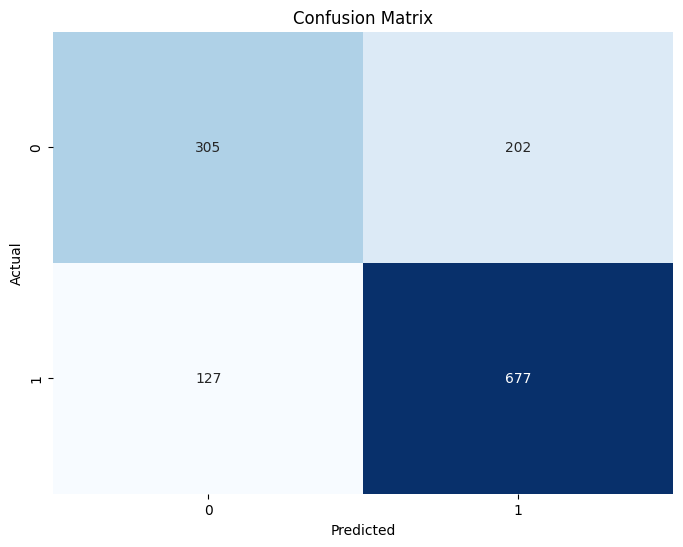

In [114]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [112]:
print(f1_score(y_test, y_pred))

0.8045157456922163


In [113]:
print(accuracy_score(y_test, y_pred))

0.7490465293668955


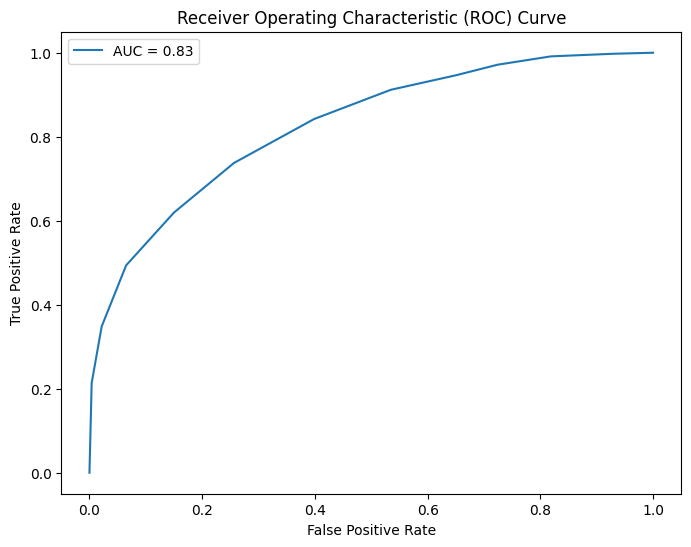

In [121]:
# ROC Curve
# Wygląda jak wykres funkcji logarytmicznej

y_prob = flag_classifier.predict_proba(X_test_scaled)[:, 1]  # Probability of being in the positive class
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

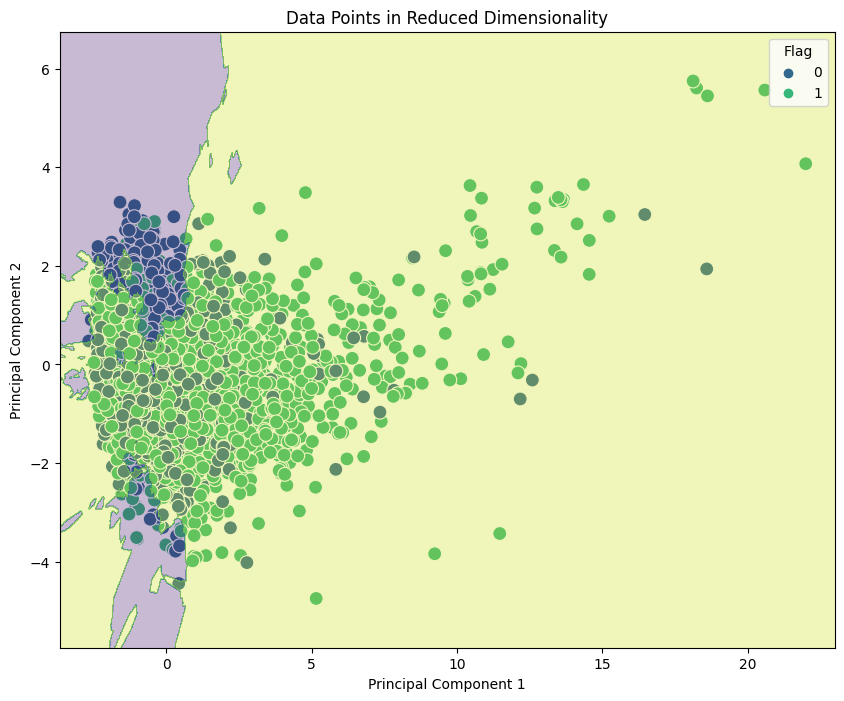

In [126]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the data to two dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot the data points
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='viridis', marker='o', s=100)
plt.title('Data Points in Reduced Dimensionality')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot the decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Transform meshgrid coordinates back to the original feature space
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
original_space_points = pca.inverse_transform(meshgrid_points)

# Make predictions in the original feature space
Z = flag_classifier.predict(original_space_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)
plt.show()
